# 0.0 IMPORTS

In [1217]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle


from IPython.core.display    import HTML
from IPython.core.display    import Image

from tabulate                import tabulate

from sklearn.preprocessing   import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics         import mean_absolute_error, mean_squared_error


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

from sklearn                 import linear_model
from sklearn.linear_model    import BayesianRidge
from sklearn.linear_model    import Lasso
from sklearn.svm             import SVR
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import Lasso

import warnings
warnings.filterwarnings( 'ignore' )

## 0.1 Loading Data

In [1218]:
df_raw = pd.read_csv('../data/processed/Absenteeism_at_work.csv', sep=';')

## 0.2 Helper Functions

In [1219]:
scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
m_result_cv = cross_validate(rf, X_train, y_train, cv=10, scoring=scoring)
np.mean(m_result_cv['test_neg_root_mean_squared_error'])

-0.21223811181126048

In [1220]:
def cross_validation(model_name:str, model:object, cv:int)-> pd.DataFrame:
    
    # model
    scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
    m_result_cv = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    
    # perfomance
    mae =  np.round(np.mean(m_result_cv['test_neg_mean_absolute_error']), 4).astype(str) + ' +/- ' + (
           np.round(np.std(m_result_cv['test_neg_mean_absolute_error']), 4).astype(str)) 
    
    mape = np.round(np.mean(m_result_cv['test_neg_mean_absolute_percentage_error']), 4).astype(str) + ' +/- ' + (
           np.round(np.std(m_result_cv['test_neg_mean_absolute_percentage_error']), 4).astype(str)) 
    
    rmse = np.round(np.mean(m_result_cv['test_neg_root_mean_squared_error']), 4).astype(str) + ' +/- ' + ( 
           np.round(np.std(m_result_cv['test_neg_root_mean_squared_error']), 4).astype(str)) 
    # result
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def mean_percentage_error(y:pd.Series, yhat:pd.Series)-> pd.Series:
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error( y:pd.Series, yhat:pd.Series )-> pd.Series:
    return np.mean(np.abs((y - yhat) / y))

def ml_error( model_name:str, y:pd.Series, yhat:pd.Series)-> pd.DataFrame:
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def jupyter_settings()-> None: 
    %matplotlib inline 
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [24, 20]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>')) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 1000
    pd.set_option('display.expand_frame_repr', False) 
    sns.set()

In [1221]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1.0 DATA DESCRIPTION

In [1222]:
df1 = df_raw

## 1.1 Rename Columns

In [1223]:
#rename
df1.columns = df1.columns.str.replace(' ','_').str.lower()

In [1224]:
df1.sample()

,id,reason_for_absence,month_of_absence,day_of_the_week,seasons,transportation_expense,distance_from_residence_to_work,service_time,age,work_load_average/day_,hit_target,disciplinary_failure,education,son,social_drinker,social_smoker,pet,weight,height,body_mass_index,absenteeism_time_in_hours
254,11,23,8,2,1,289,36,13,33,265.615,94,0,1,2,1,0,1,90,172,30,1


## 1.2 Data Dimensions

In [1225]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 740
Number of Cols: 21


## 1.3 Data Types

In [1226]:
df1.dtypes

id                                   int64
reason_for_absence                   int64
month_of_absence                     int64
day_of_the_week                      int64
seasons                              int64
transportation_expense               int64
distance_from_residence_to_work      int64
service_time                         int64
age                                  int64
work_load_average/day_             float64
hit_target                           int64
disciplinary_failure                 int64
education                            int64
son                                  int64
social_drinker                       int64
social_smoker                        int64
pet                                  int64
weight                               int64
height                               int64
body_mass_index                      int64
absenteeism_time_in_hours            int64
dtype: object

### 1.4 Check NA

In [1227]:
df1.isna().sum()

id                                 0
reason_for_absence                 0
month_of_absence                   0
day_of_the_week                    0
seasons                            0
transportation_expense             0
distance_from_residence_to_work    0
service_time                       0
age                                0
work_load_average/day_             0
hit_target                         0
disciplinary_failure               0
education                          0
son                                0
social_drinker                     0
social_smoker                      0
pet                                0
weight                             0
height                             0
body_mass_index                    0
absenteeism_time_in_hours          0
dtype: int64

## 1.5 Descriptive Statistical

In [1228]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.5.1 Numerical Attributes

In [1229]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000,36.000,35.000,18.017568,18.000,11.013798,0.016606,-1.251818
1,reason_for_absence,0.000,28.000,28.000,19.216216,23.000,8.427706,-0.915312,-0.259925
2,month_of_absence,0.000,12.000,12.000,6.324324,6.000,3.433964,0.069369,-1.254967
3,day_of_the_week,2.000,6.000,4.000,3.914865,4.000,1.420714,0.102440,-1.286406
4,seasons,1.000,4.000,3.000,2.544595,3.000,1.111080,-0.038532,-1.345190
5,transportation_expense,118.000,388.000,270.000,221.329730,225.000,66.906970,0.396189,-0.318291
6,distance_from_residence_to_work,5.000,52.000,47.000,29.631081,26.000,14.826760,0.312083,-1.261683
7,service_time,1.000,29.000,28.000,12.554054,13.000,4.381910,-0.004720,0.683111
8,age,27.000,58.000,31.000,36.450000,37.000,6.474393,0.697703,0.431613
9,work_load_average/day_,205.917,378.884,172.967,271.490235,264.249,39.031717,0.961457,0.618188


# 2.0 FEATURE ENGINEERING

## 2.1 Hypothesis Mind Map

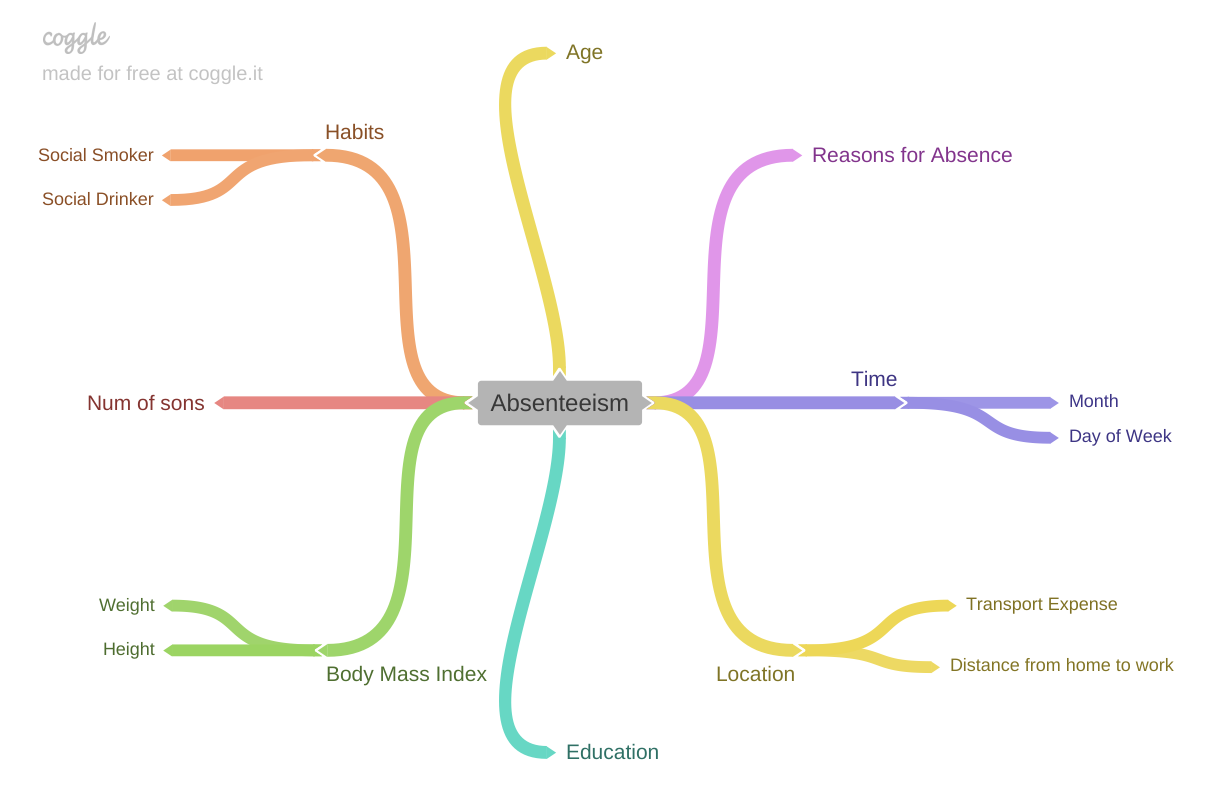

In [1246]:
Image('../MindMapHipothesis.png')

## 2.2 List of Hypothesis

**H1.** The most frequency reason for absence is factors influencing health status and contact with health services.

**H2.** The absnce month with highest occurrence of absences is December.

**H3.** The day of the week with the highest occurrence of absences is Monday.

**H4.** The lower the transport expense, the greater the adherence to work.

**H5.** The junior the age, more the absences.

**H6.** The highest education, the greather adherence to work.

**H7.** The highest number of sons, more the absences.

**H8.** Employees who drink socially, plus absences.

**H9.** Employees who smokes socially, plus absences.

**H10.** The highest weight, more the absences.

**H11.** The highest distance from residence to work, more the absences.

## 2.2 Feature Engineering

# 3.0 DATA FILTERING

# 4.0 DATA EXPLORATORY ANALYSIS

In [1247]:
df2 = df1.copy()

## 4.1 Univariate Analysis

### 4.1.2 Response  Variable

<AxesSubplot:xlabel='absenteeism_time_in_hours', ylabel='Count'>

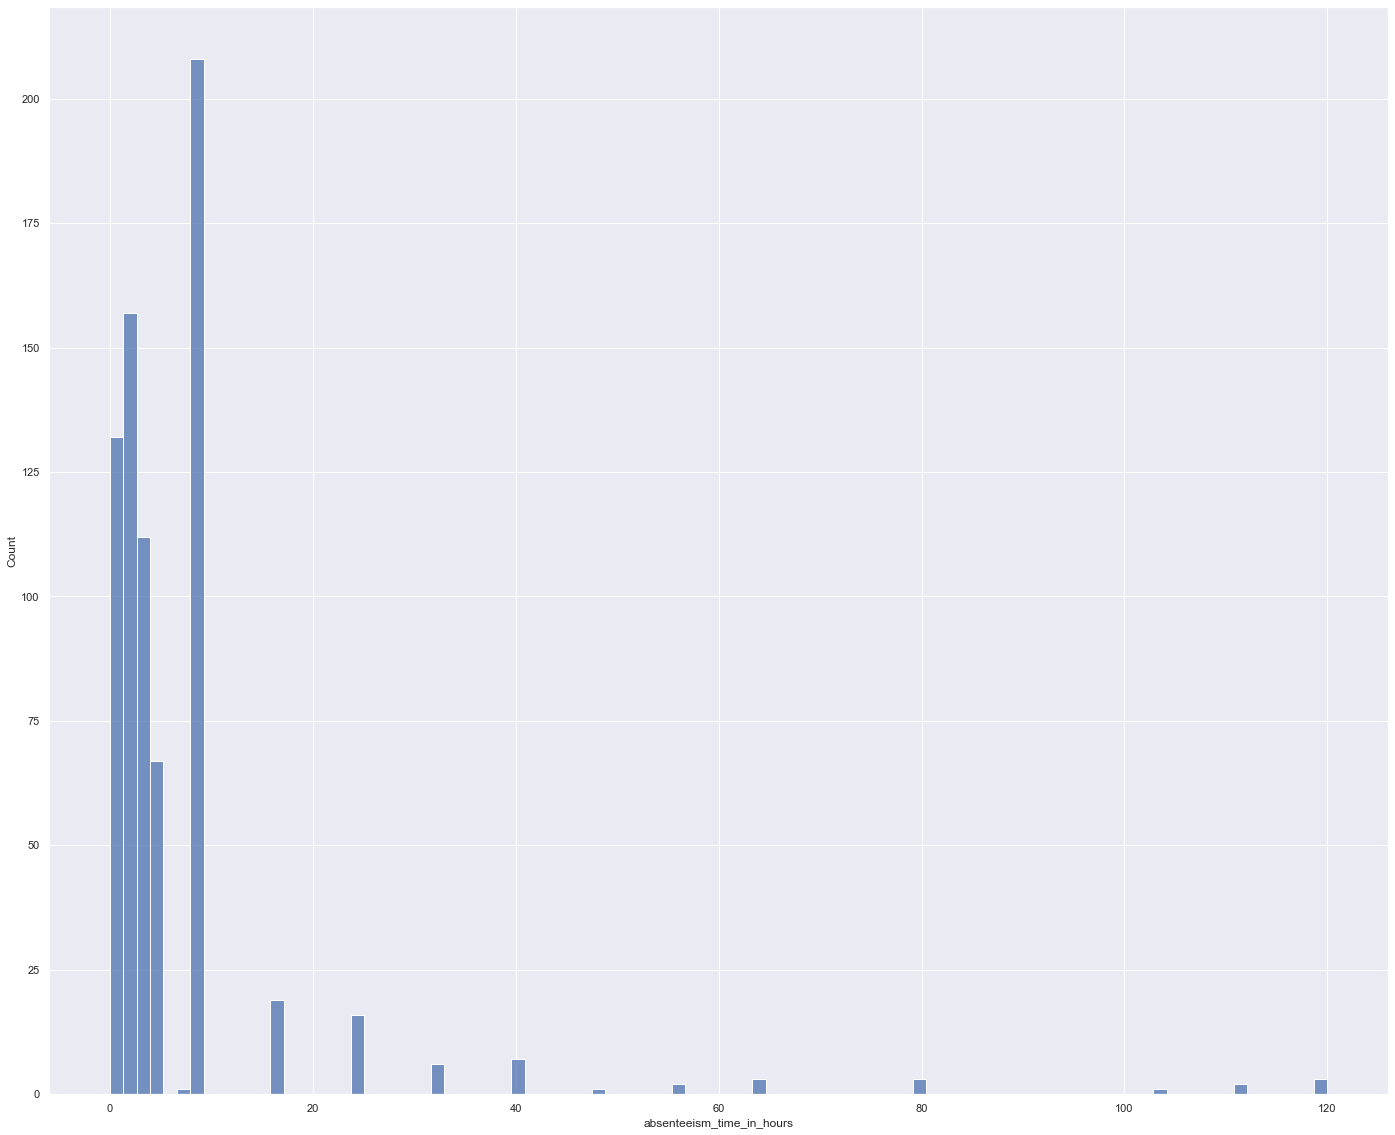

In [1248]:
sns.histplot(df1['absenteeism_time_in_hours'])

### 4.1.3 Numerical Variables

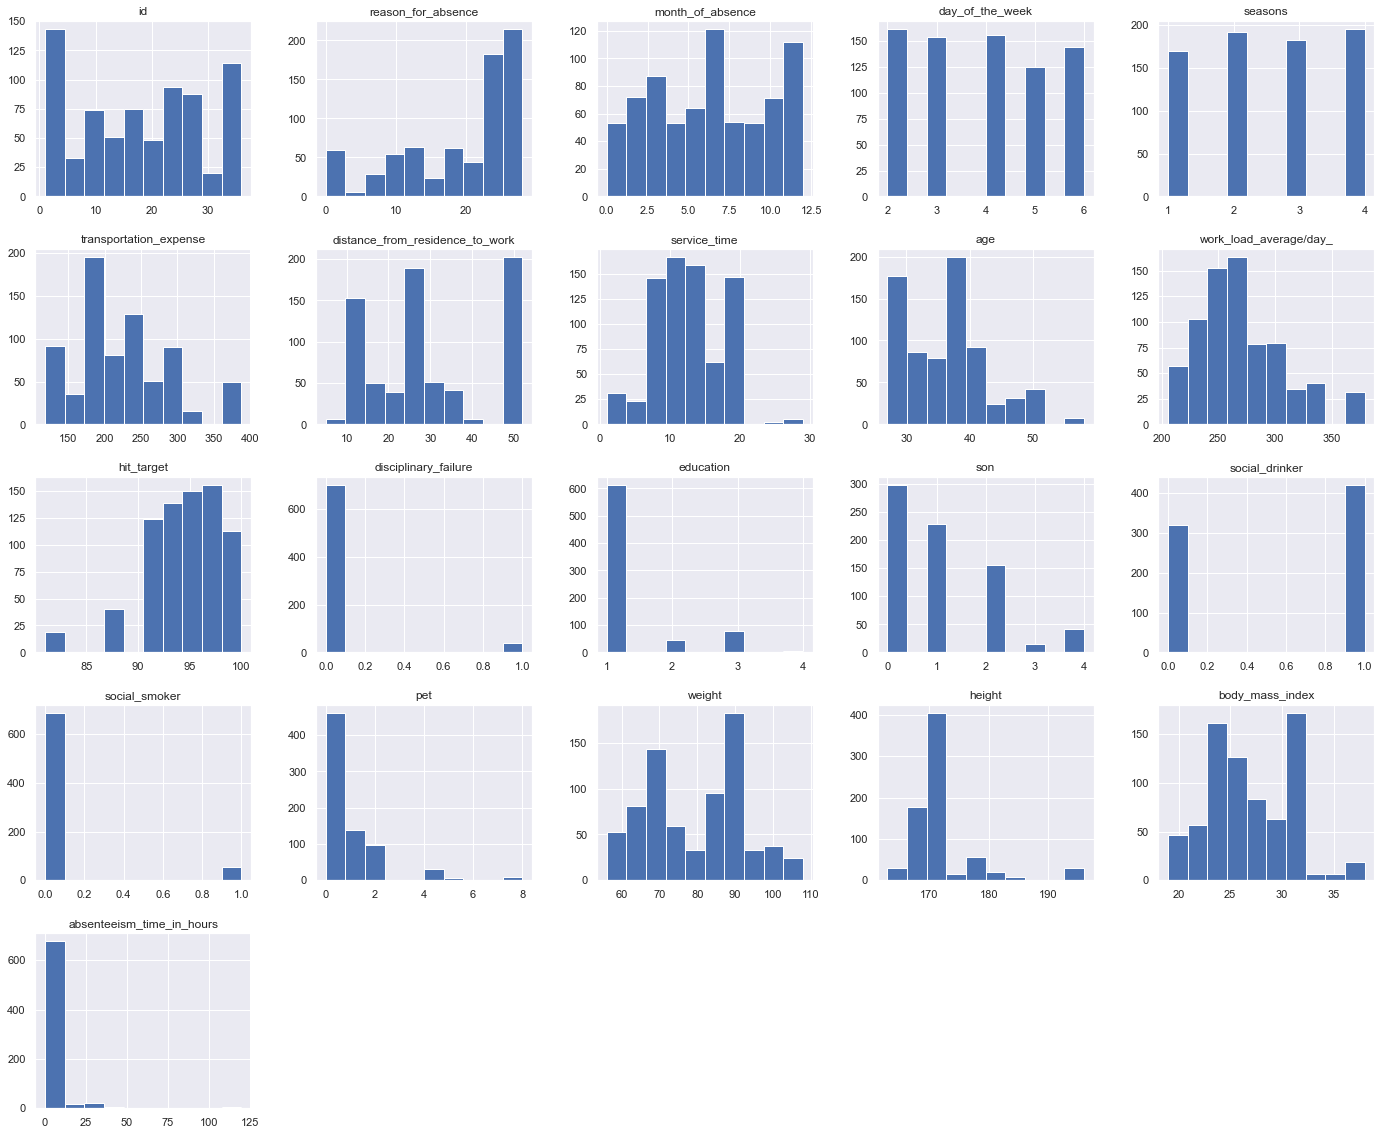

In [1249]:
num_attributes.hist();

## 4.2 Bivariate Analysis

### **H1.** The most frequency reason for absence is factors influencing health status and contact with health services.
**FALSE** Diseases of the musculoskeletal system and connective tissue is the most frequency resos for absence.

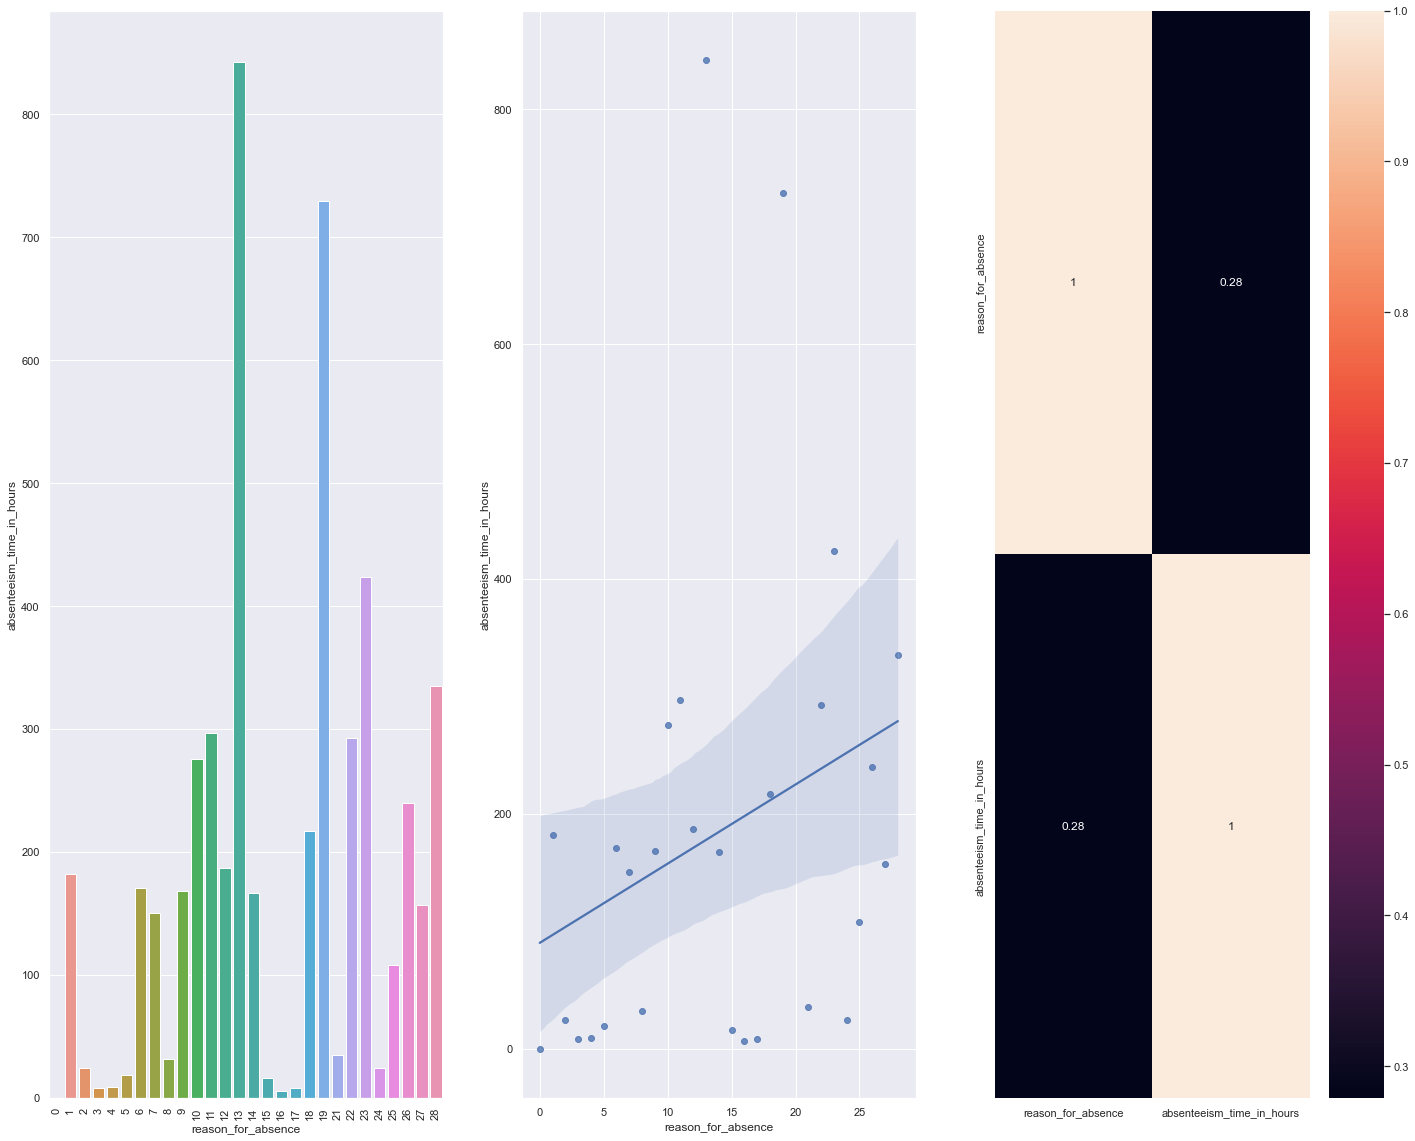

In [1250]:
aux1 = df2[['absenteeism_time_in_hours', 'reason_for_absence']].groupby('reason_for_absence').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='reason_for_absence', y='absenteeism_time_in_hours', data=aux1 );
xticks(rotation=90)

plt.subplot( 1, 3, 2 )
sns.regplot( x='reason_for_absence', y='absenteeism_time_in_hours', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H2.** The absnce month with highest occurrence of absences is December.
**FALSE** The absnce month with highest occurrence of absences is March. 

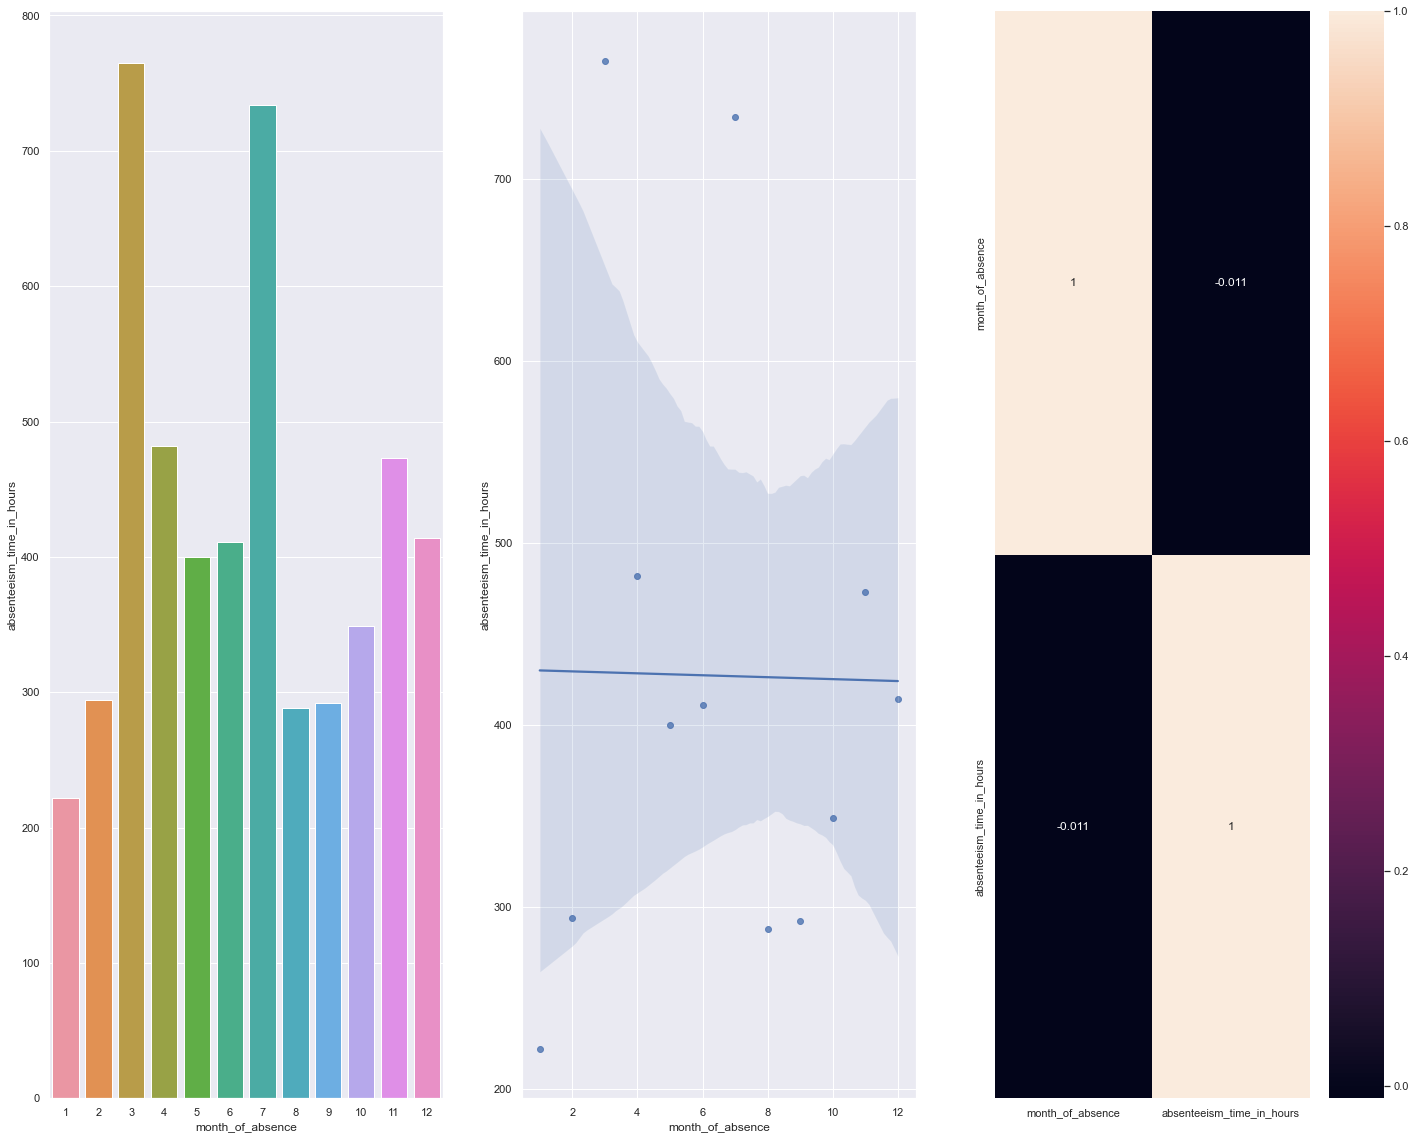

In [1251]:
aux1 = df2[['absenteeism_time_in_hours', 'month_of_absence']].query('month_of_absence >0').groupby('month_of_absence').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='month_of_absence', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot( x='month_of_absence', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** The day of the week with the highest occurrence of absences is Monday.
**TRUE** The day of the week with the highest occurrence of absences is Monday.

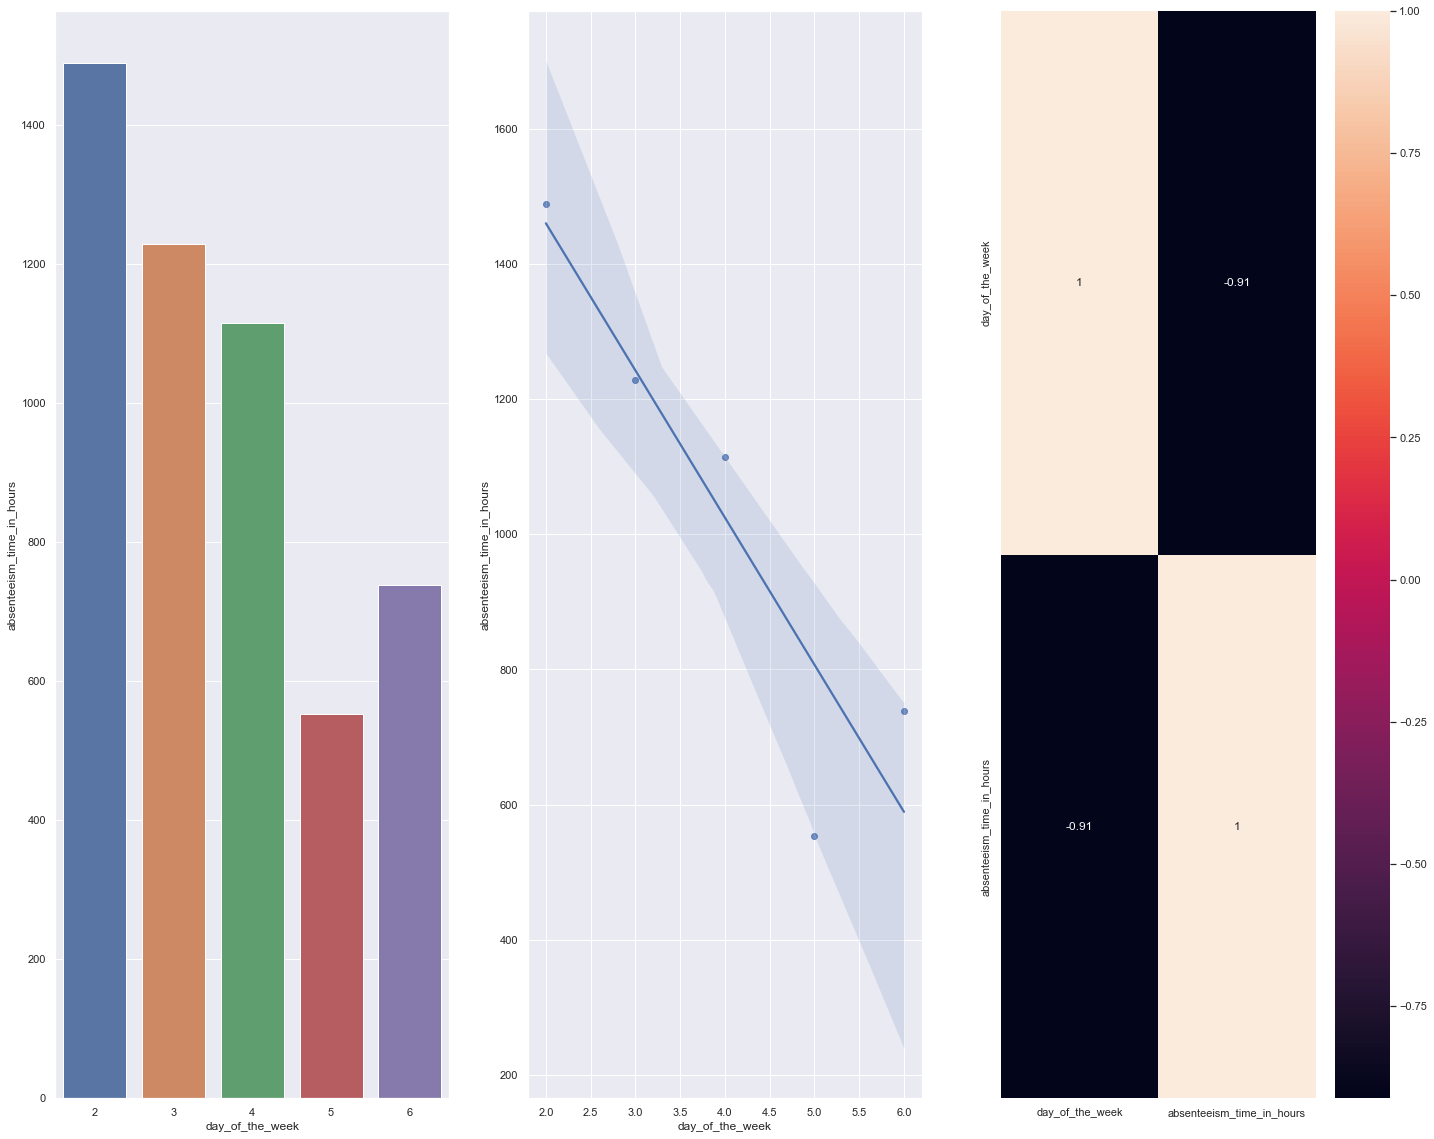

In [1252]:
aux1 = df2[['absenteeism_time_in_hours', 'day_of_the_week']].groupby('day_of_the_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='day_of_the_week', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_the_week', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** The lower the transport expense, the greater the adherence to work.
**FALSE** The lower the transport expense, is not greater the adherence to work.

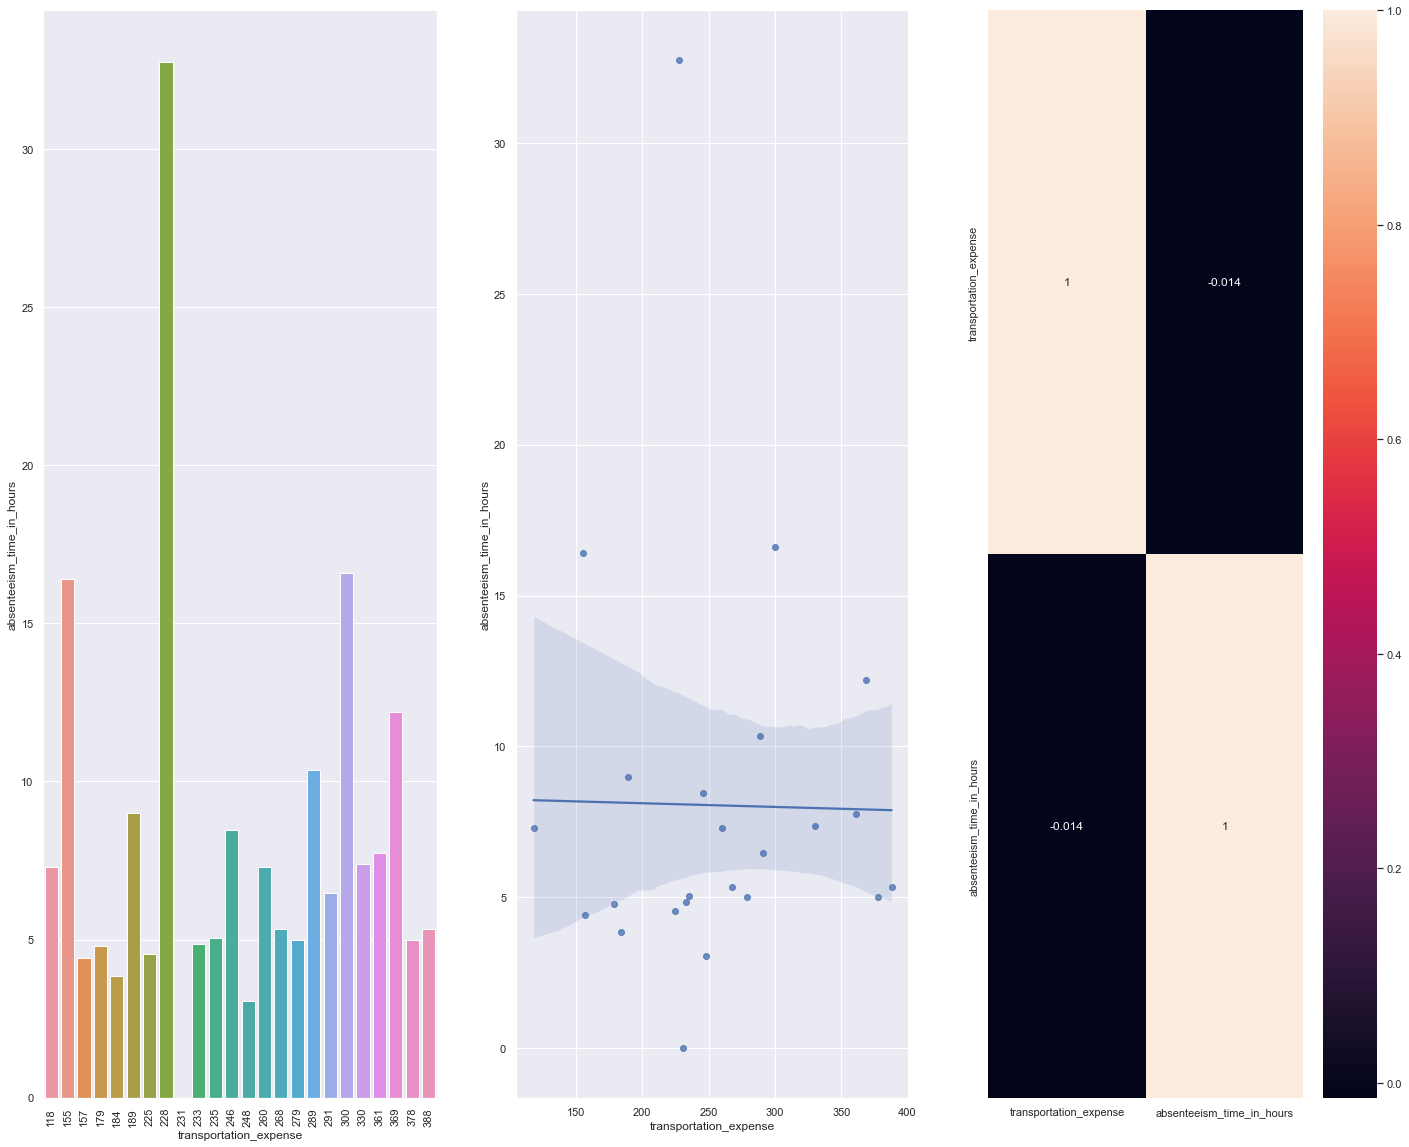

In [1253]:
aux1 = df2[['absenteeism_time_in_hours', 'transportation_expense']].groupby('transportation_expense').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='transportation_expense', y='absenteeism_time_in_hours', data=aux1);
xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot( x='transportation_expense', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H5.** The junior the age, more the absences.
**FALSE** The junior the age, less the absences.

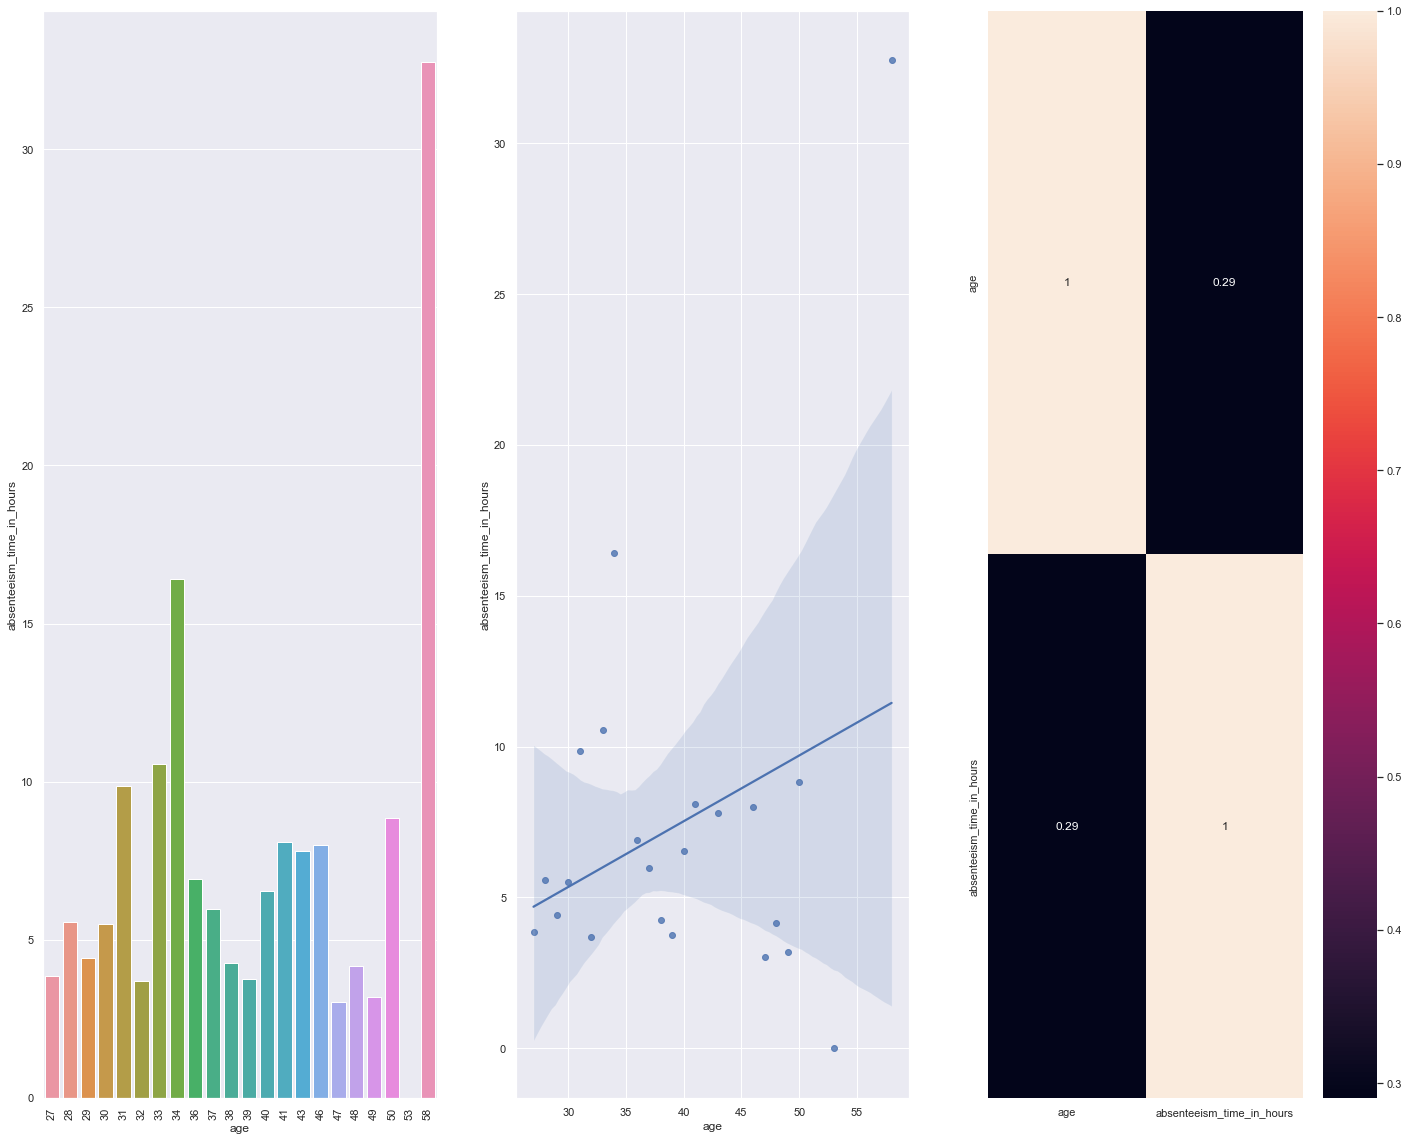

In [1254]:
aux1 = df2[['absenteeism_time_in_hours', 'age']].groupby('age').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='age', y='absenteeism_time_in_hours', data=aux1);
xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot( x='age', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H6.** The highest education, the greather adherence to work.
**FALSE** The highest education, less adherence to work.

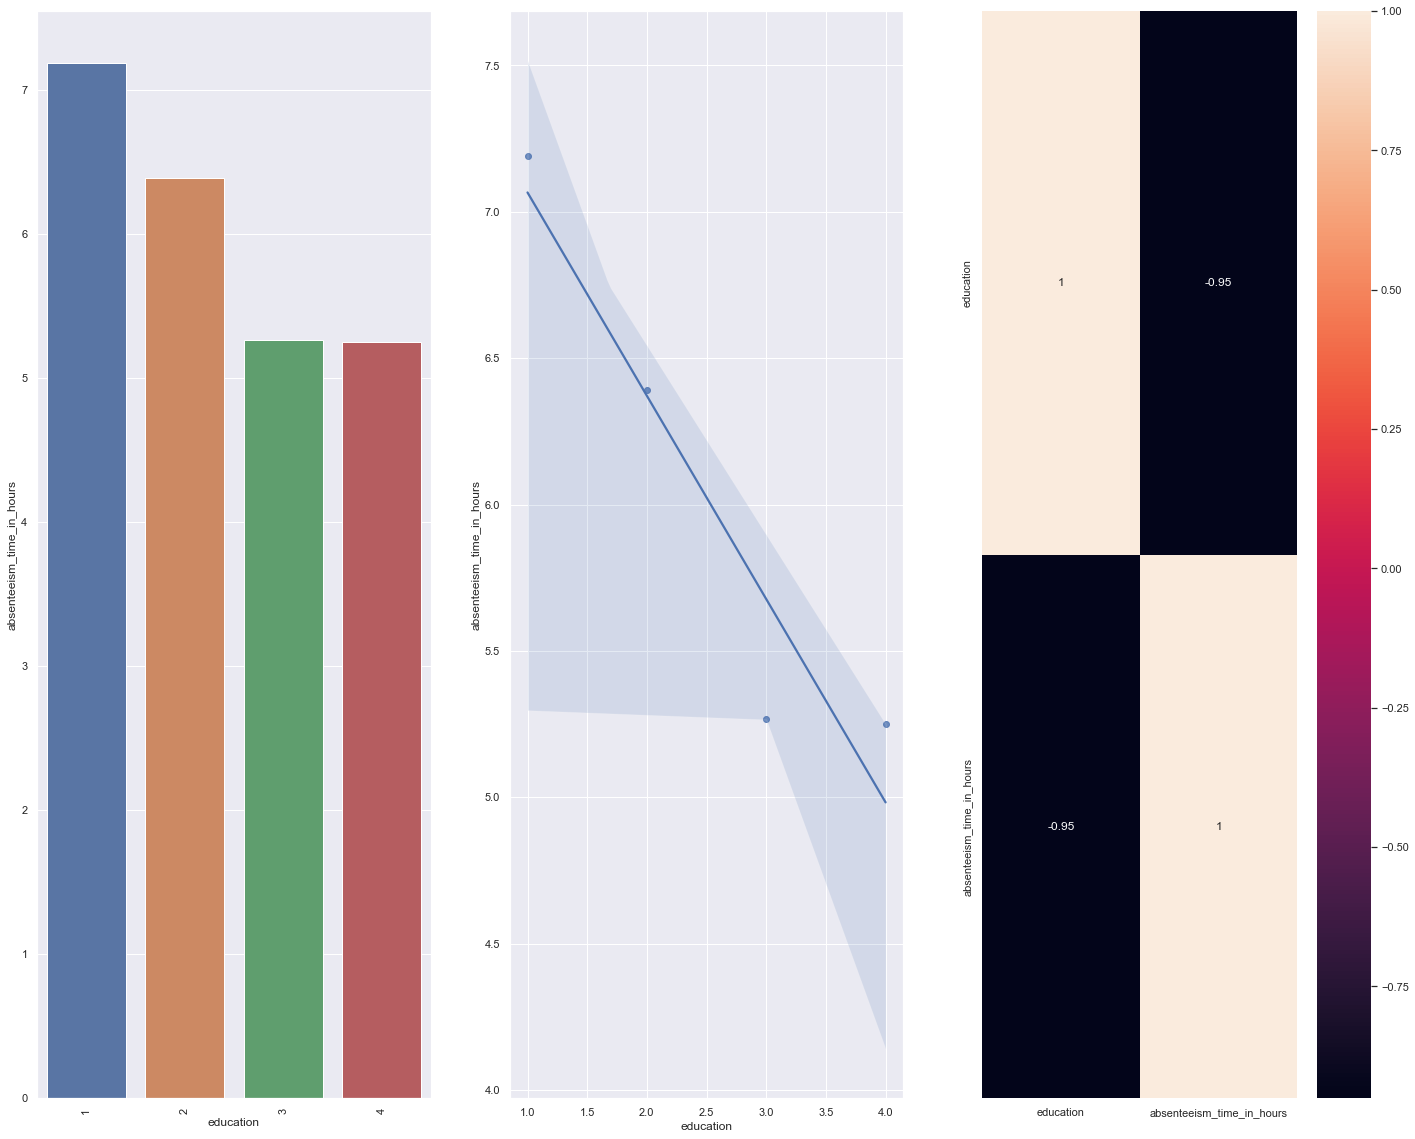

In [1255]:
aux1 = df2[['absenteeism_time_in_hours', 'education']].groupby('education').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='education', y='absenteeism_time_in_hours', data=aux1);
xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot( x='education', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H7.** The highest number of sons, more the absences.
**FALSE** The highest number of sons, less the absences.

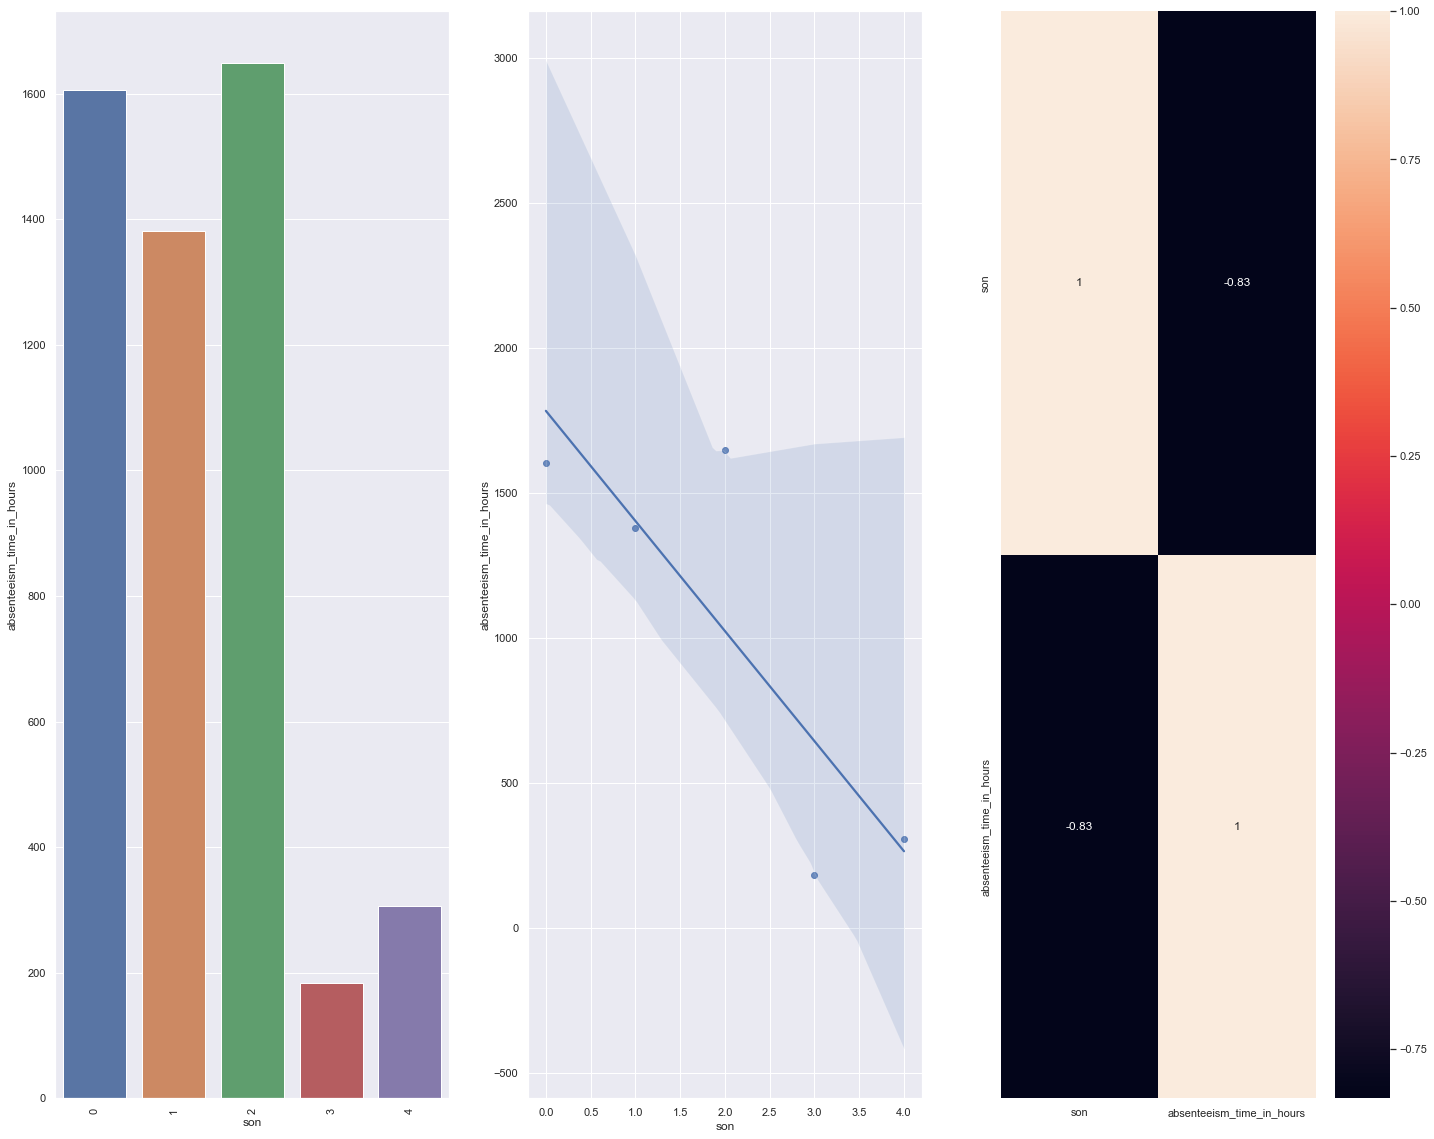

In [1256]:
aux1 = df2[['absenteeism_time_in_hours', 'son']].groupby('son').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='son', y='absenteeism_time_in_hours', data=aux1);
xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot( x='son', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H8.** Employees who drink socially, plus absences.
**TRUE** Employees who drink socially, more absences.

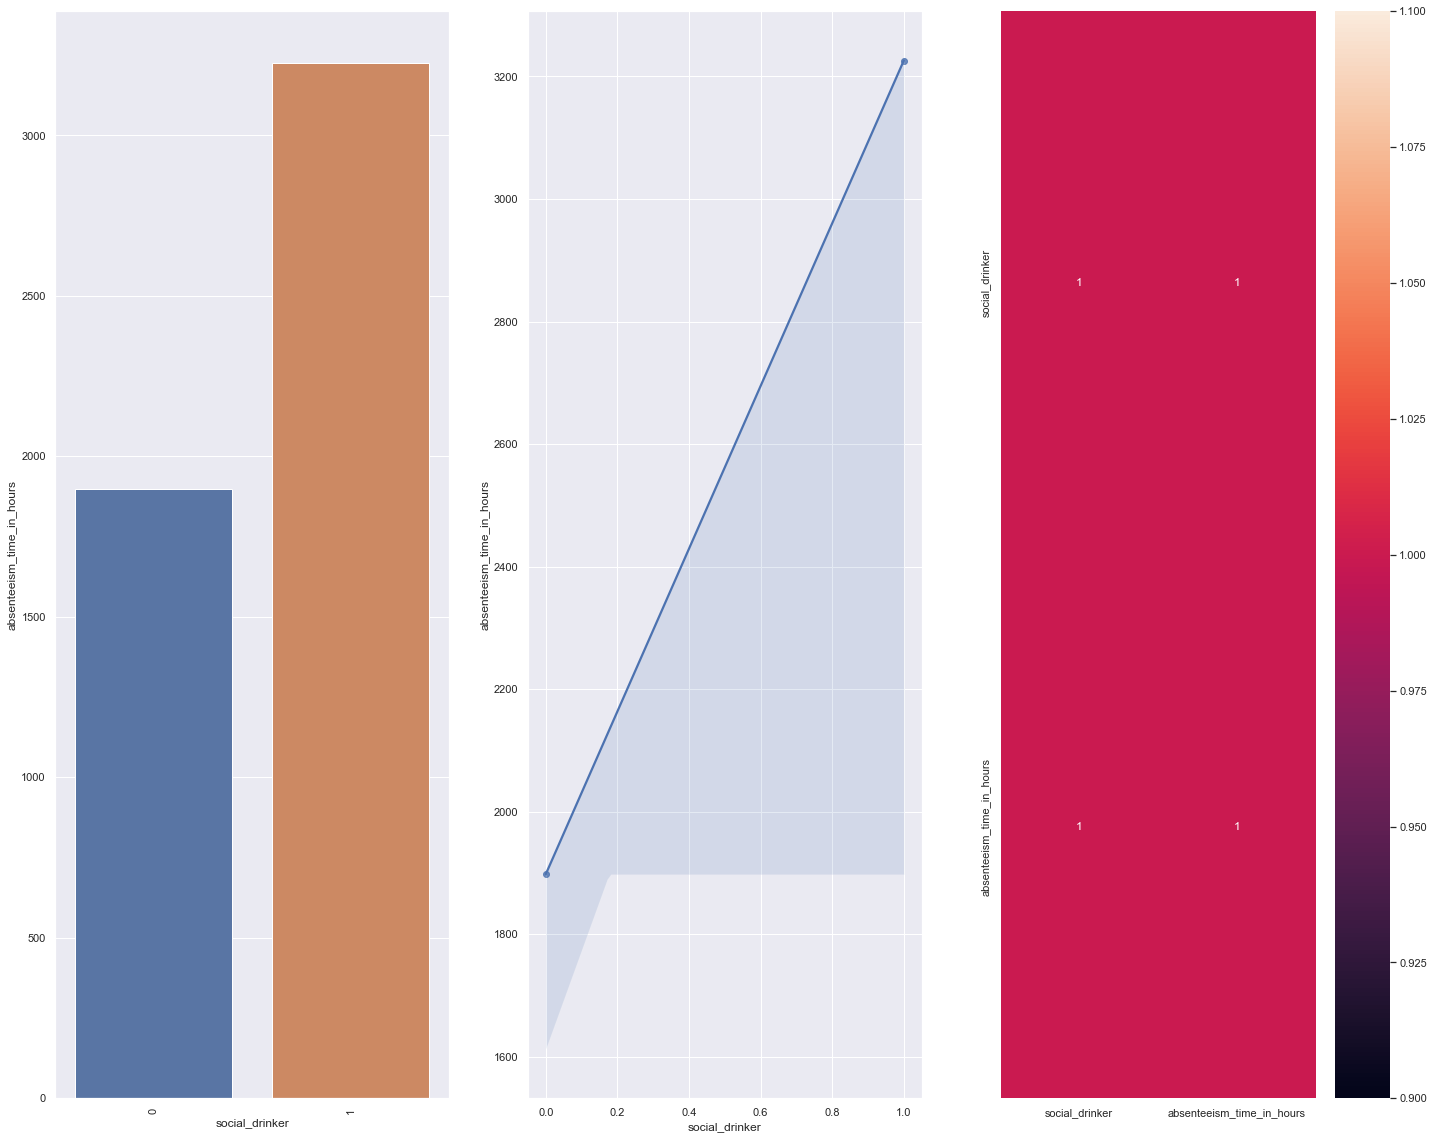

In [1257]:
aux1 = df2[['absenteeism_time_in_hours', 'social_drinker']].groupby('social_drinker').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='social_drinker', y='absenteeism_time_in_hours', data=aux1);
xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot( x='social_drinker', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Employees who smokes socially, plus absences.
**FALSE** Employees who smokes socially, less the absences.

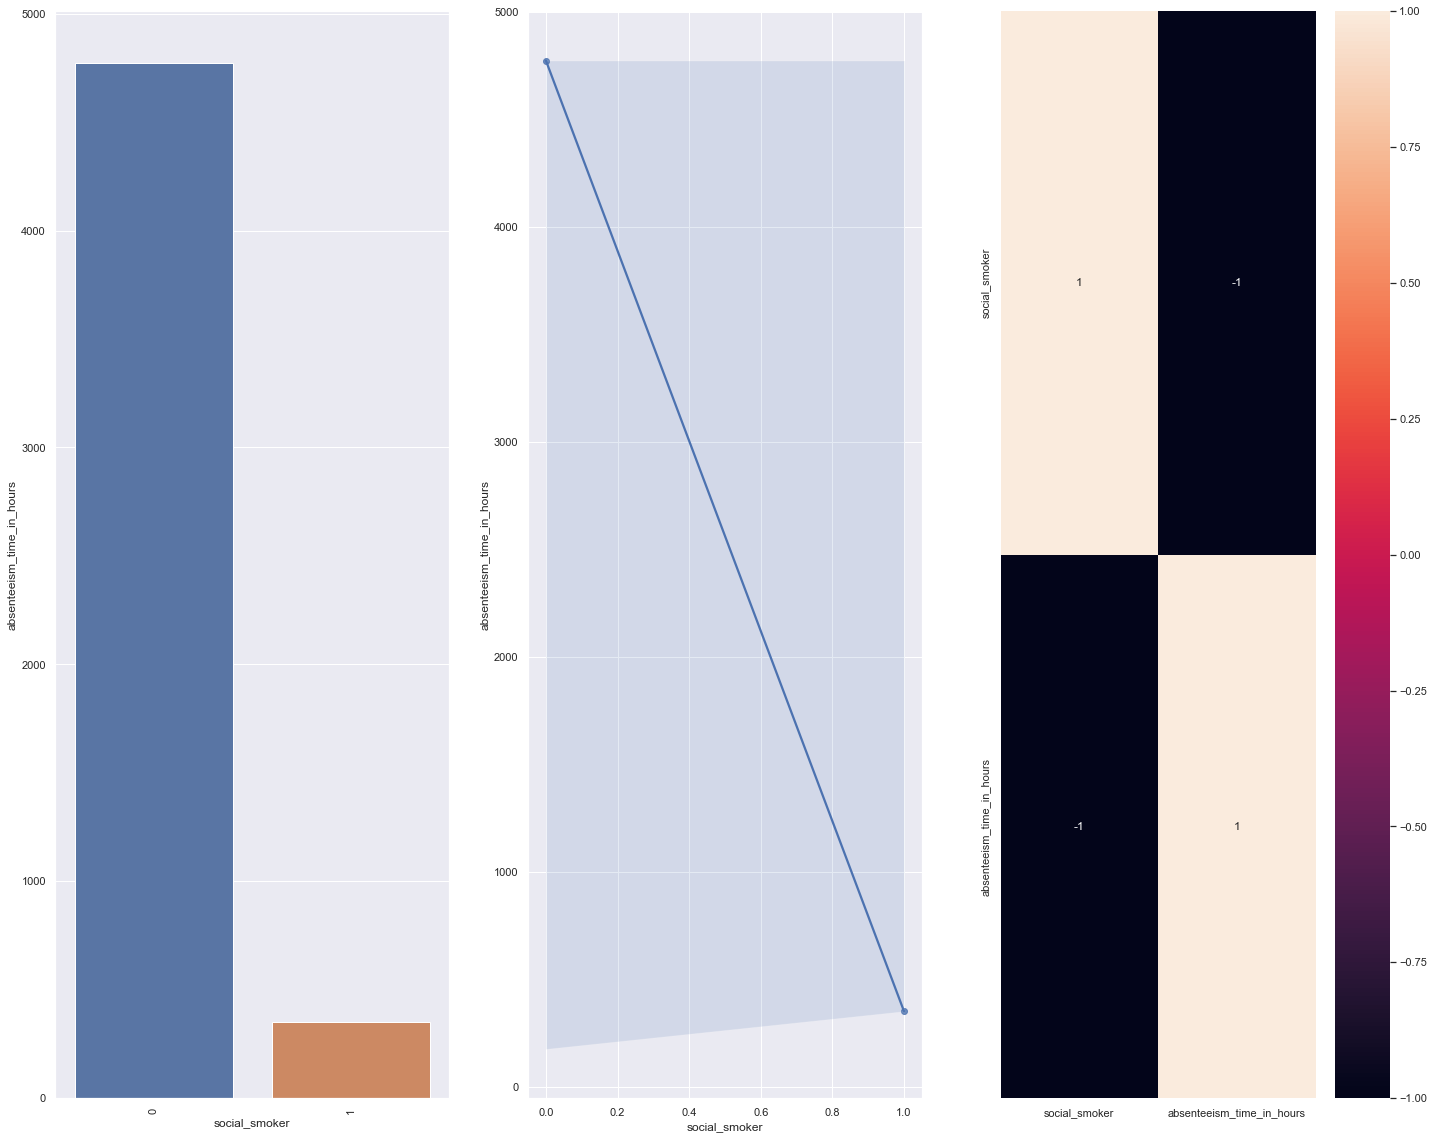

In [1258]:
aux1 = df2[['absenteeism_time_in_hours', 'social_smoker']].groupby('social_smoker').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='social_smoker', y='absenteeism_time_in_hours', data=aux1);
xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot( x='social_smoker', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** The lowest body mass index, more the adherence to work.
**FALSE** The lowest body mass index, more the absence.

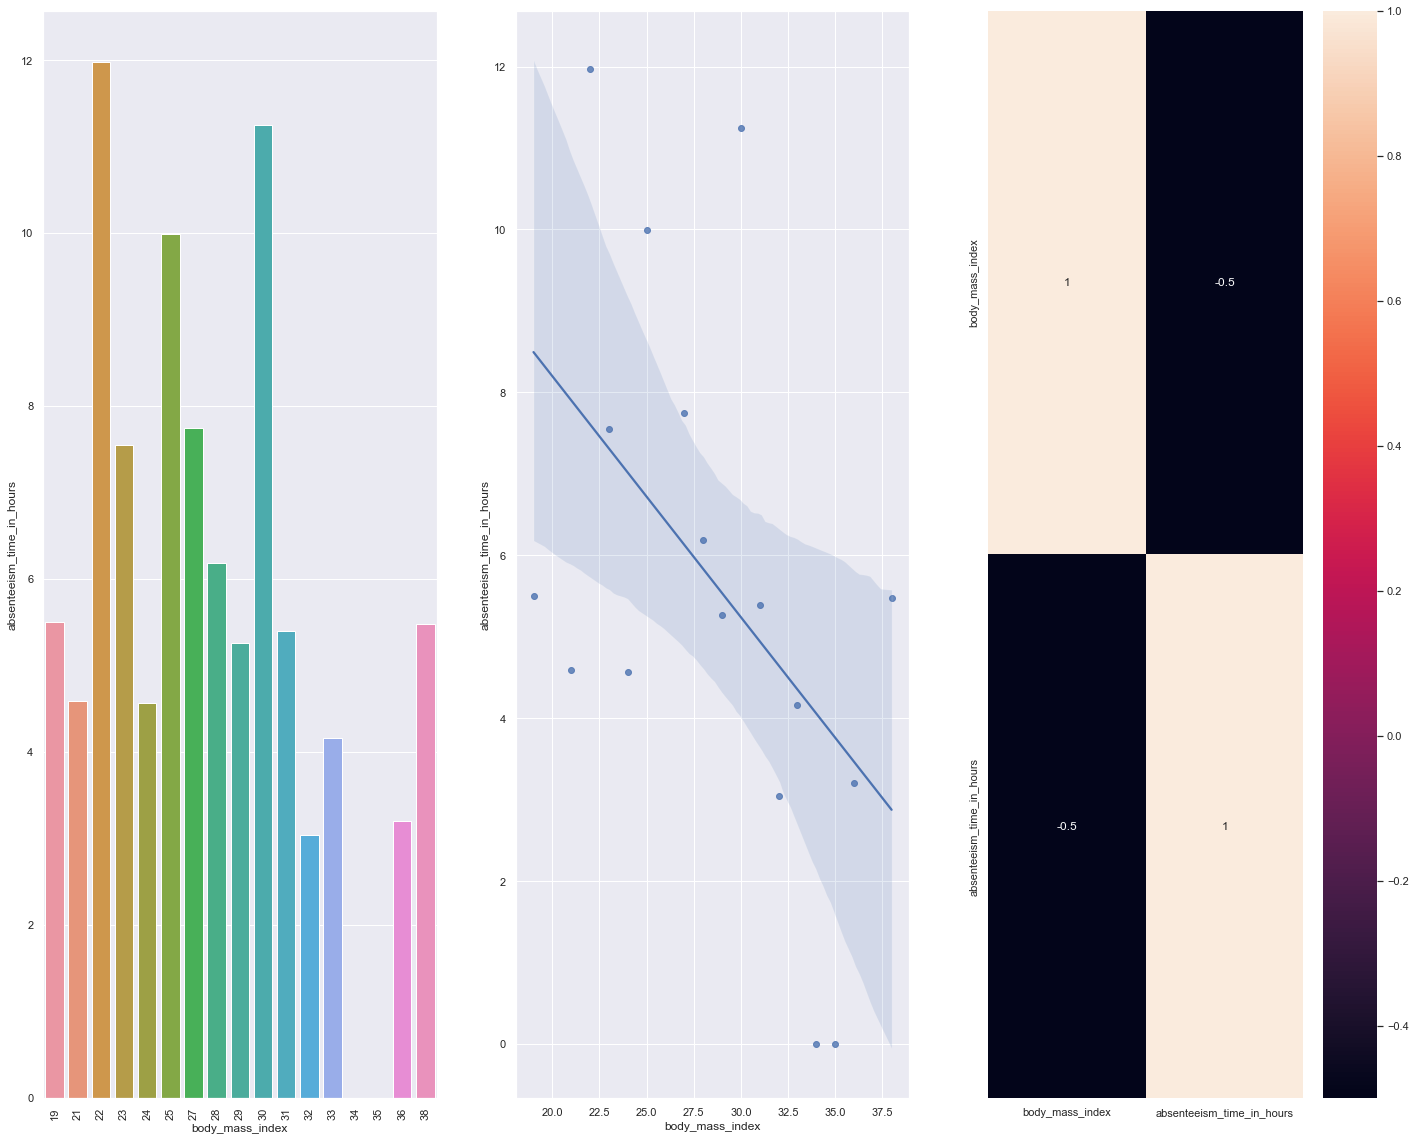

In [1259]:
aux1 = df2[['absenteeism_time_in_hours', 'body_mass_index']].groupby('body_mass_index').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='body_mass_index', y='absenteeism_time_in_hours', data=aux1);
xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot( x='body_mass_index', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H11.** The highest distance from residence to work, more the absences.
**FALSE** The highest distance from residence to work, less the absences.

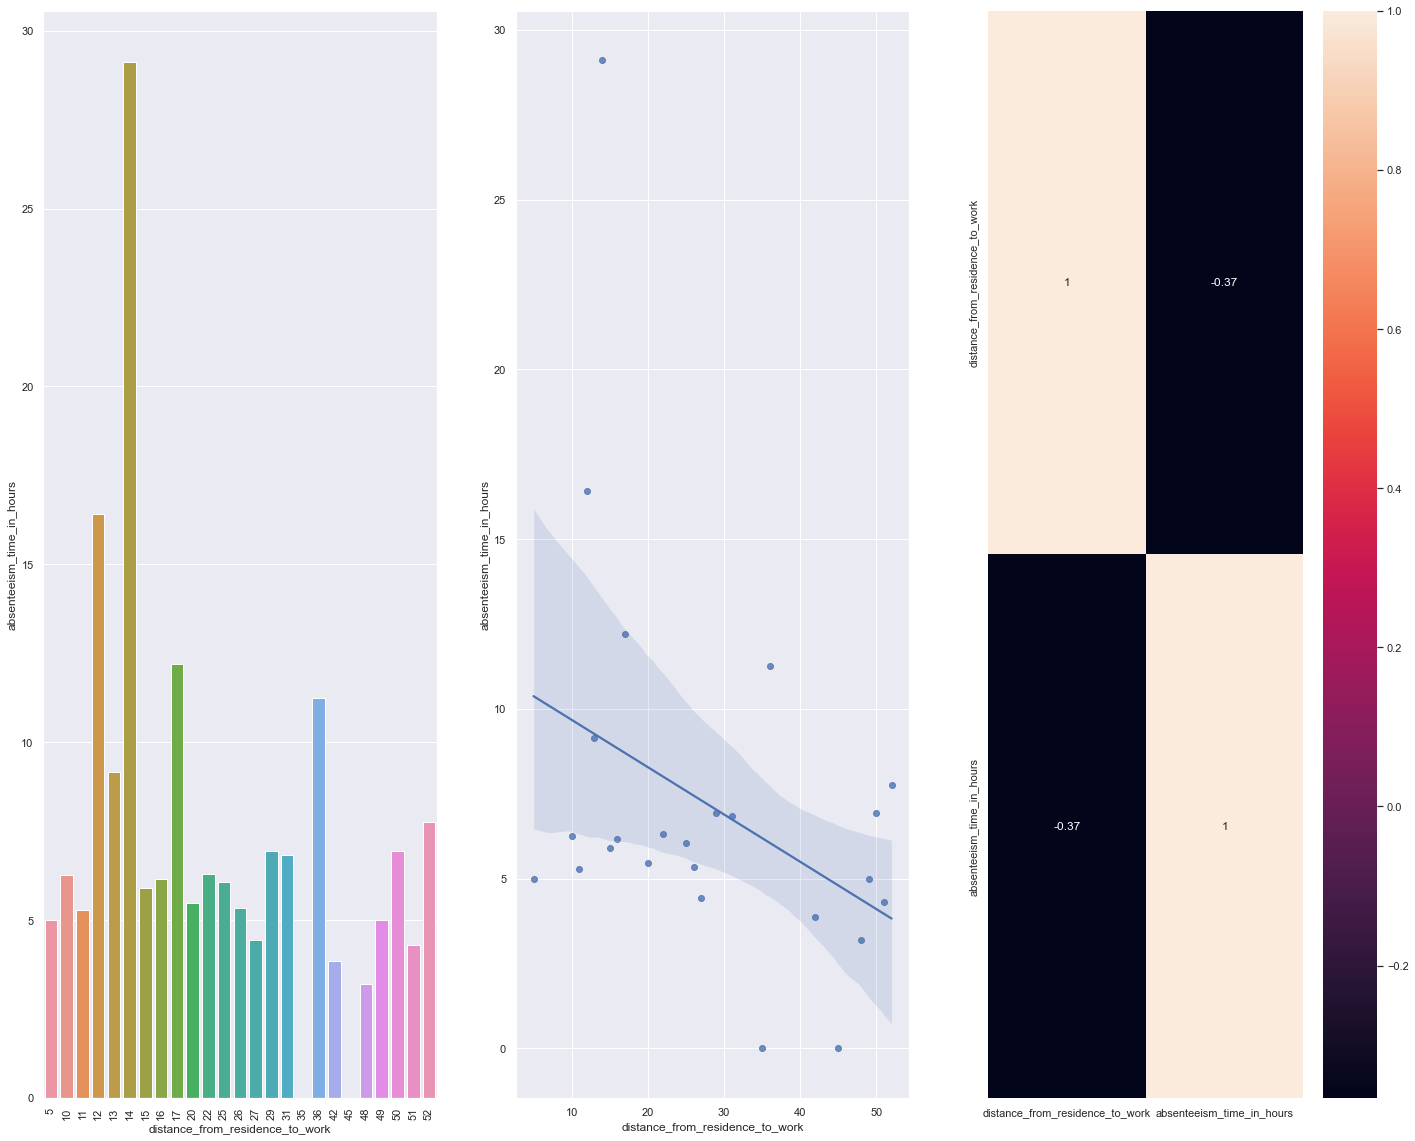

In [1260]:
aux1 = df2[['absenteeism_time_in_hours', 'distance_from_residence_to_work']].groupby('distance_from_residence_to_work').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='distance_from_residence_to_work', y='absenteeism_time_in_hours', data=aux1);
xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot( x='distance_from_residence_to_work', y='absenteeism_time_in_hours', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot:>

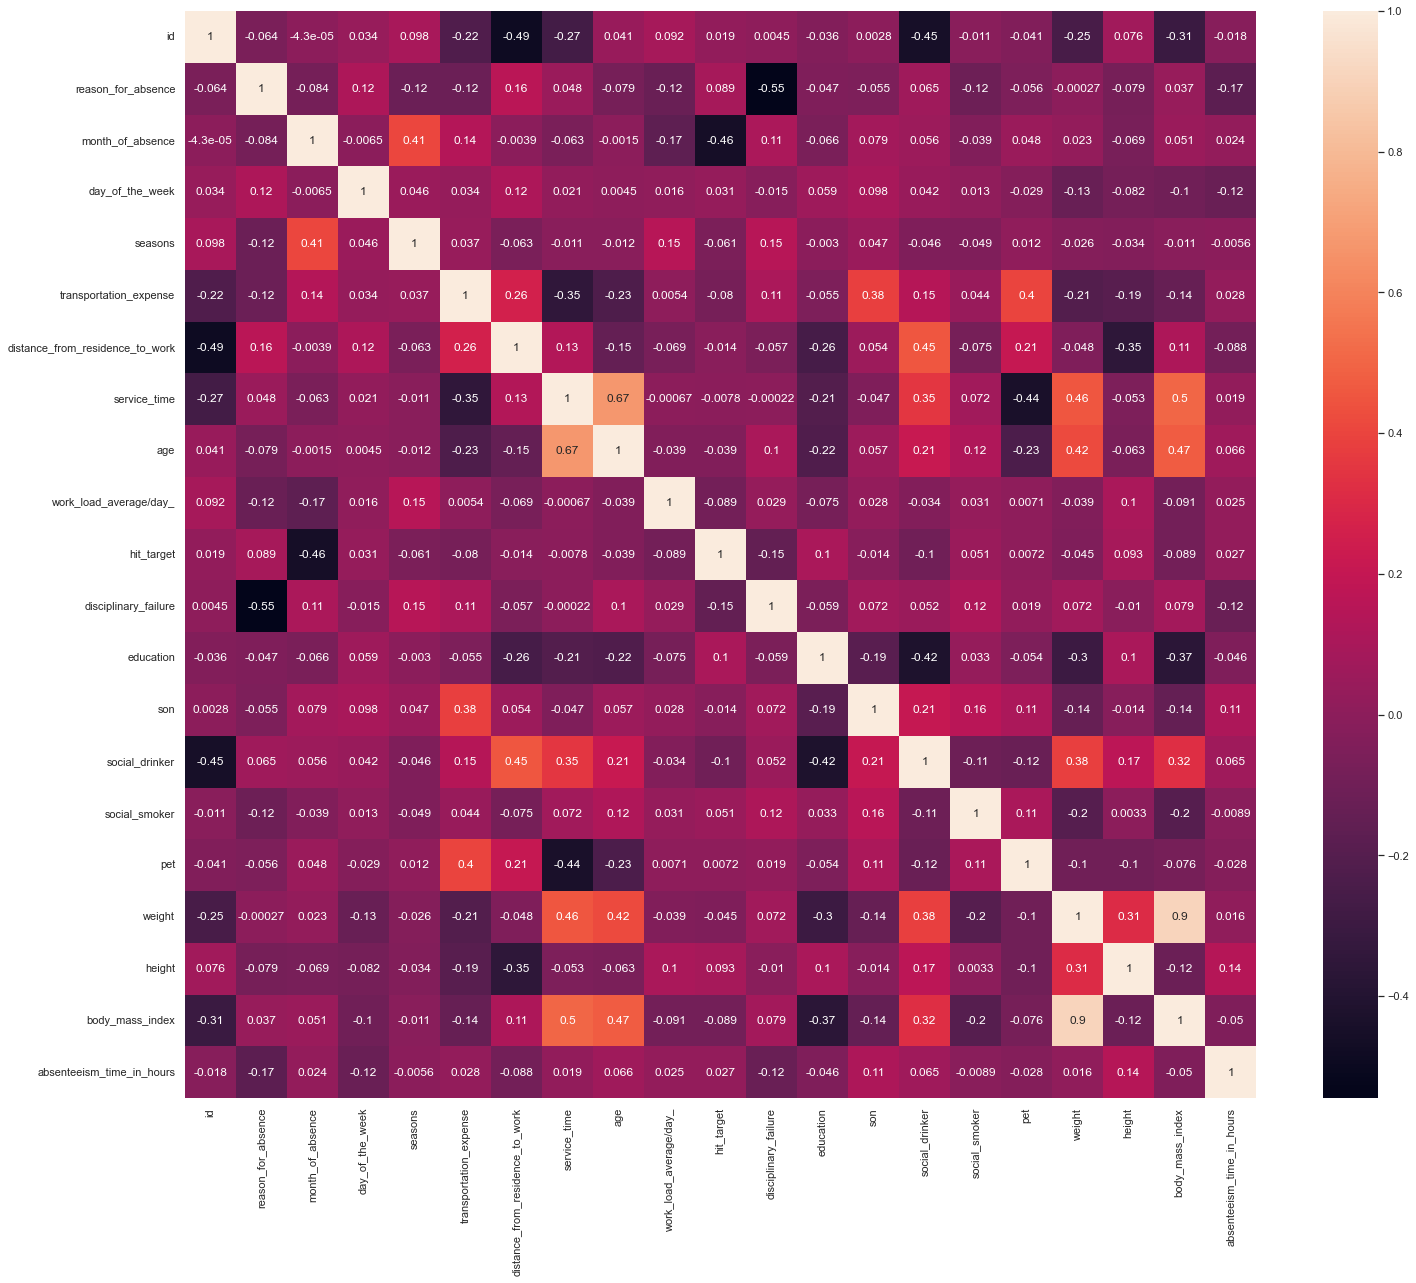

In [1261]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

## 4.4 Summary of Hypotheses

In [1262]:
headers = ['Hipothesis', 'Conclusion', 'Relevancy']
           
tab = [
    ['H1', 'False', 'High'],
    ['H2', 'False', 'High'],
    ['H3', 'True', 'High'],
    ['H4', 'False', 'Low'],
    ['H5', 'False', 'High'],
    ['H6', 'False', 'Low'],
    ['H7', 'False', 'Low'],
    ['H8', 'True', 'High'],
    ['H9', 'False', 'High'],
    ['H10', 'False', 'High'],
    ['H11', 'False', 'Medium'],
      ]
print( tabulate( tab, headers=headers, showindex="always"))

    Hipothesis    Conclusion    Relevancy
--  ------------  ------------  -----------
 0  H1            False         High
 1  H2            False         High
 2  H3            True          High
 3  H4            False         Low
 4  H5            False         High
 5  H6            False         Low
 6  H7            False         Low
 7  H8            True          High
 8  H9            False         High
 9  H10           False         High
10  H11           False         Medium


# 5.0 DATA PREPARATION

In [1499]:
df3 = df2.copy()

## 5.1 Responsable Variable Transformation

In [1500]:
df3['absenteeism_time_in_hours_log'] = np.log1p(df3['absenteeism_time_in_hours']) 

## 5.1.2 Scaling

In [1501]:
scaler = StandardScaler()

scaler.fit(df3)

df3 = pd.DataFrame(scaler.transform(df3), columns=df3.columns) 

# 6.0 FEATURE SELECTION

## 6.1 Split Data Into Train and Test

In [1534]:
X = df3.drop(['id', 'absenteeism_time_in_hours', 'absenteeism_time_in_hours_log'], axis=1)
y = df3['absenteeism_time_in_hours_log']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

## 6.1 Boruta as Feature Selector

In [1535]:
#from sklearn.ensemble import RandomForestRegressor
#from boruta import BorutaPy
#
##training and test dataset for boruta
#X_train_n = X_train.values
#y_train_n = y_train.values.ravel()
#
##define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1, random_state=42)
#
##define boruta
#boruta = BorutaPy(rf, verbose=2, random_state=42).fit(X_train_n, y_train_n)

##best features from boruta
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta

#cols_selected_boruta = ['reason_for_absence', 'age']

# 7.0 MACHINE LEARNING MODELING

## 7.2 Linear Regressor Model

In [1536]:
# model
lr = linear_model.LinearRegression().fit(X_train, y_train)

# predict
yhat_lr = lr.predict(X_test)

# result
lr_result = ml_error('Linear Regressor', y_test, yhat_lr)
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor,0.573695,1.932428,0.78099


## 7.1 Linear Regressor Model - Cross Validation

In [1537]:
lr_cv = cross_validation('Linear Regressor', lr, cv=5)
lr_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor,-0.583 +/- 0.0376,-1.666 +/- 0.2069,-0.8129 +/- 0.0613


## 7.3 XGBoost Regressor

In [1538]:
import xgboost as xgb

# model
xgb = xgb.XGBRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# prediction
yhat_xgb = xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', y_test , yhat_xgb  )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,0.513683,2.15194,0.780056


## 7.3.2 XGBoost Regressor- Cross Validation

In [1539]:
xgb_cv = cross_validation('XGBoost Regressor', xgb, cv=5)
xgb_cv

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,-0.5445 +/- 0.0481,-1.9938 +/- 0.4244,-0.7722 +/- 0.0525


## 7.4 Bayesian Regression Ridge

In [1540]:
# model
br = BayesianRidge().fit(X_train, y_train)

# predict
yhat_br = br.predict(X_test)

# result
br_result = ml_error('Bayesin Ridge Regression', y_test, yhat_br)
br_result

,Model Name,MAE,MAPE,RMSE
0,Bayesin Ridge Regression,0.569326,1.807978,0.777842


## 7.4 Bayesian Regression Ridge - Cross Validation

In [1541]:
br_cv = cross_validation('Bayesin Ridge Regression', br, cv=5)
br_cv

,Model Name,MAE,MAPE,RMSE
0,Bayesin Ridge Regression,-0.5848 +/- 0.0461,-1.5701 +/- 0.1384,-0.8118 +/- 0.0704


## 7.5 Support Vector Machine - Linear Kernel

In [1542]:

# model
svm = SVR(C=1).fit(X_train, y_train)

# predict
yhat_svm = svm.predict(X_test)

# result
svm_result = ml_error('Support Vector Machine', y_test, yhat_svm)
svm_result 

,Model Name,MAE,MAPE,RMSE
0,Support Vector Machine,0.544863,1.950356,0.789398


## 7.5.2 Support Vector Machine (Linear Kernel) - Cross Validation

In [1543]:
svm_cv = cross_validation('Support Vector Machine (Linear Kernel)', svm, cv=5)
svm_cv

,Model Name,MAE,MAPE,RMSE
0,Support Vector Machine (Linear Kernel),-0.5794 +/- 0.0591,-1.6552 +/- 0.2656,-0.815 +/- 0.0782


## 7.6 Random Forest Regressor

In [1544]:
# model
rf = RandomForestRegressor().fit(X_train, y_train)

# predict
yhat_rf = rf.predict(X_test)

# result
rf_result = ml_error('Random Forest Regressor', y_test,  yhat_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.467746,1.790408,0.730606


## 7.6.2 Random Forest Regresor - Cross Validation

In [1545]:
rf_cv = cross_validation('Random Forest Regressor', rf, cv=5)
rf_cv

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,-0.4943 +/- 0.0264,-1.9112 +/- 0.24,-0.7029 +/- 0.0507


In [1546]:
filename = '../models/model.pkl'
model = pickle.dump(rf, open(filename, 'wb'))

## 7.7 Compare Model's Perfomance

## 7.7.1 Single Performance

In [1547]:
modelling_result = pd.concat([lr_result, xgb_result, rf_result, svm_result, br_result])
modelling_result.sort_values('RMSE', ascending=True)

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.467746,1.790408,0.730606
0,Bayesin Ridge Regression,0.569326,1.807978,0.777842
0,XGBoost Regressor,0.513683,2.151940,0.780056
0,Linear Regressor,0.573695,1.932428,0.780990
0,Support Vector Machine,0.544863,1.950356,0.789398


##   7.7.2 Real Performance - Cross Validation

In [1548]:
modelling_result_cv = pd.concat([lr_cv, xgb_cv, rf_cv, svm_cv, br_cv])
modelling_result_cv.sort_values('RMSE', ascending= True)

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,-0.4943 +/- 0.0264,-1.9112 +/- 0.24,-0.7029 +/- 0.0507
0,XGBoost Regressor,-0.5445 +/- 0.0481,-1.9938 +/- 0.4244,-0.7722 +/- 0.0525
0,Bayesin Ridge Regression,-0.5848 +/- 0.0461,-1.5701 +/- 0.1384,-0.8118 +/- 0.0704
0,Linear Regressor,-0.583 +/- 0.0376,-1.666 +/- 0.2069,-0.8129 +/- 0.0613
0,Support Vector Machine (Linear Kernel),-0.5794 +/- 0.0591,-1.6552 +/- 0.2656,-0.815 +/- 0.0782


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search CV

In [1549]:
#from sklearn.model_selection import RandomizedSearchCV
#
#n_estimators = [100, 200, 300, 500]
#
#max_depth = [3, 5, 10, None]
#
#min_samples_leaf = [1, 2, 4]
#
#min_samples_split = [1, 2, 4]
#
#max_features = ['auto', 'sqrt']
#
#criterion = ['squared_error', 'absolute_error', 'poisson']
#
#
## creating random grid
#
#params = {
#    'n_estimators': n_estimators,
#    'max_depth': max_depth,
#    'min_samples_leaf': min_samples_leaf,
#    'min_samples_split': min_samples_split,
#    'max_features': max_features,
#    'criterion': criterion
#         }

In [1550]:
#random_search = RandomizedSearchCV(estimator=rf,
#                                  param_distributions=params, 
#                                  n_iter=5,
#                                  n_jobs=-1, 
#                                  cv=10, 
#                                  verbose=2,
#                                  random_state=42)
#
#random_search.fit(X_train, y_train)
#random_search.best_params_

In [1551]:
#params_tuned = {'n_estimators': 300,
# 'min_samples_split': 2,
# 'min_samples_leaf': 2,
# 'max_features': 'sqrt',
# 'max_depth': None,
# 'criterion': 'squared_error'}

In [1552]:
# model
rf_tuned = RandomForestRegressor(n_estimators=300,
                                min_samples_split=2,
                                min_samples_leaf=2,
                                max_features='sqrt',
                                max_depth=None,
                                criterion='squared_error').fit(X_train, y_train)

# predict
yhat_rf_tuned = rf_tuned.predict(X_test)

# result
rf_tuned_result = ml_error('Random Forest Regressor',  y_test, yhat_rf_tuned)
rf_tuned_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.50021,1.436408,0.739914


In [1553]:
filename = '../models/model_tuned.pkl'
model = pickle.dump(rf_tuned, open(filename, 'wb'))

# 9.0 TRADUTION AND INTERPRETATE  ERROR

In [1554]:
df9 = X_test

df9['absenteeism_time_in_hours'] = df3['absenteeism_time_in_hours'] 
df9['predictions'] = np.expm1(yhat_rf_tuned)
df9['id'] = df2['id']

##  9.1. Business Performance

In [1555]:
# sum of predictions
df91 = df9[['id', 'predictions']].groupby('id').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['id', 'absenteeism_time_in_hours', 'predictions']].groupby('id').apply(lambda x: mean_absolute_error( x['absenteeism_time_in_hours'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['id', 'absenteeism_time_in_hours', 'predictions']].groupby('id').apply(lambda x: mean_absolute_percentage_error( x['absenteeism_time_in_hours'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='id' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='id' )

# Scenarios
df92['best_scenario'] = df92['predictions'] - df92['MAE']
df92['worst_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['id','predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df92['absenteeism_time_in_hours'] = df3['absenteeism_time_in_hours']

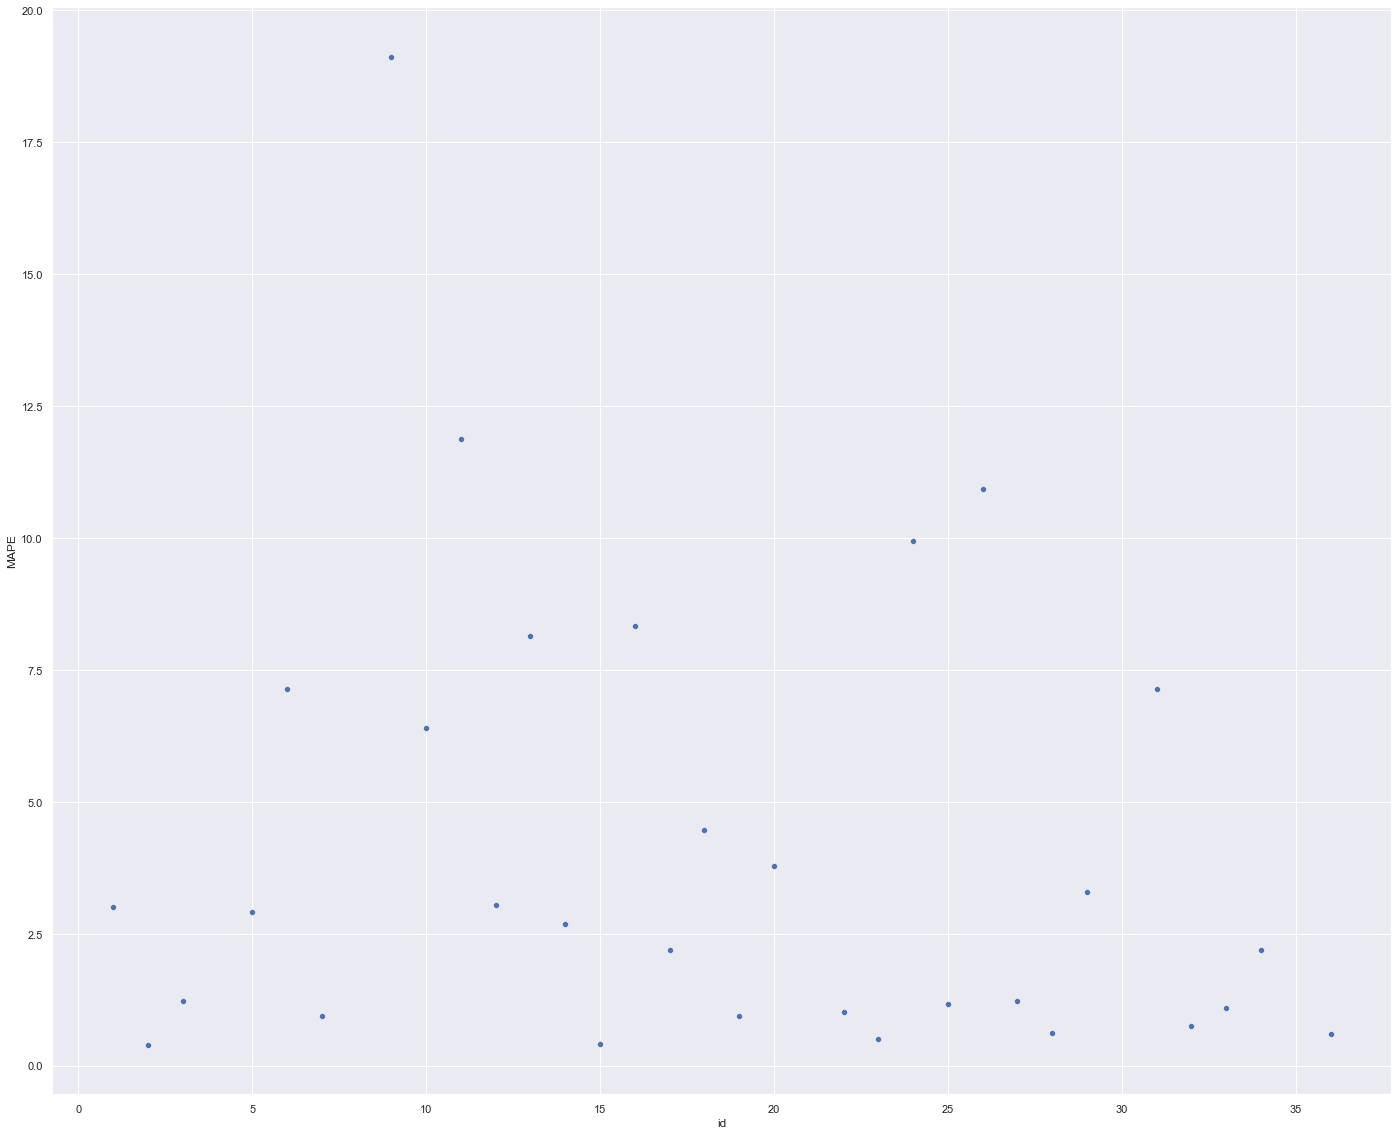

In [1556]:
sns.scatterplot( x='id', y='MAPE', data=df92);

##  9.2. Total Performance

In [1557]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93

,Scenario,Values
0,predictions,48.185944
1,worst_scenario,69.198104
2,best_scenario,27.173784


##  9.3. Machine Learning Performance

In [1558]:
df9['error'] = df9['absenteeism_time_in_hours'] - df9['predictions'] 
df9['error_rate'] = df9['predictions'] / df9['absenteeism_time_in_hours']

<AxesSubplot:xlabel='predictions', ylabel='error'>

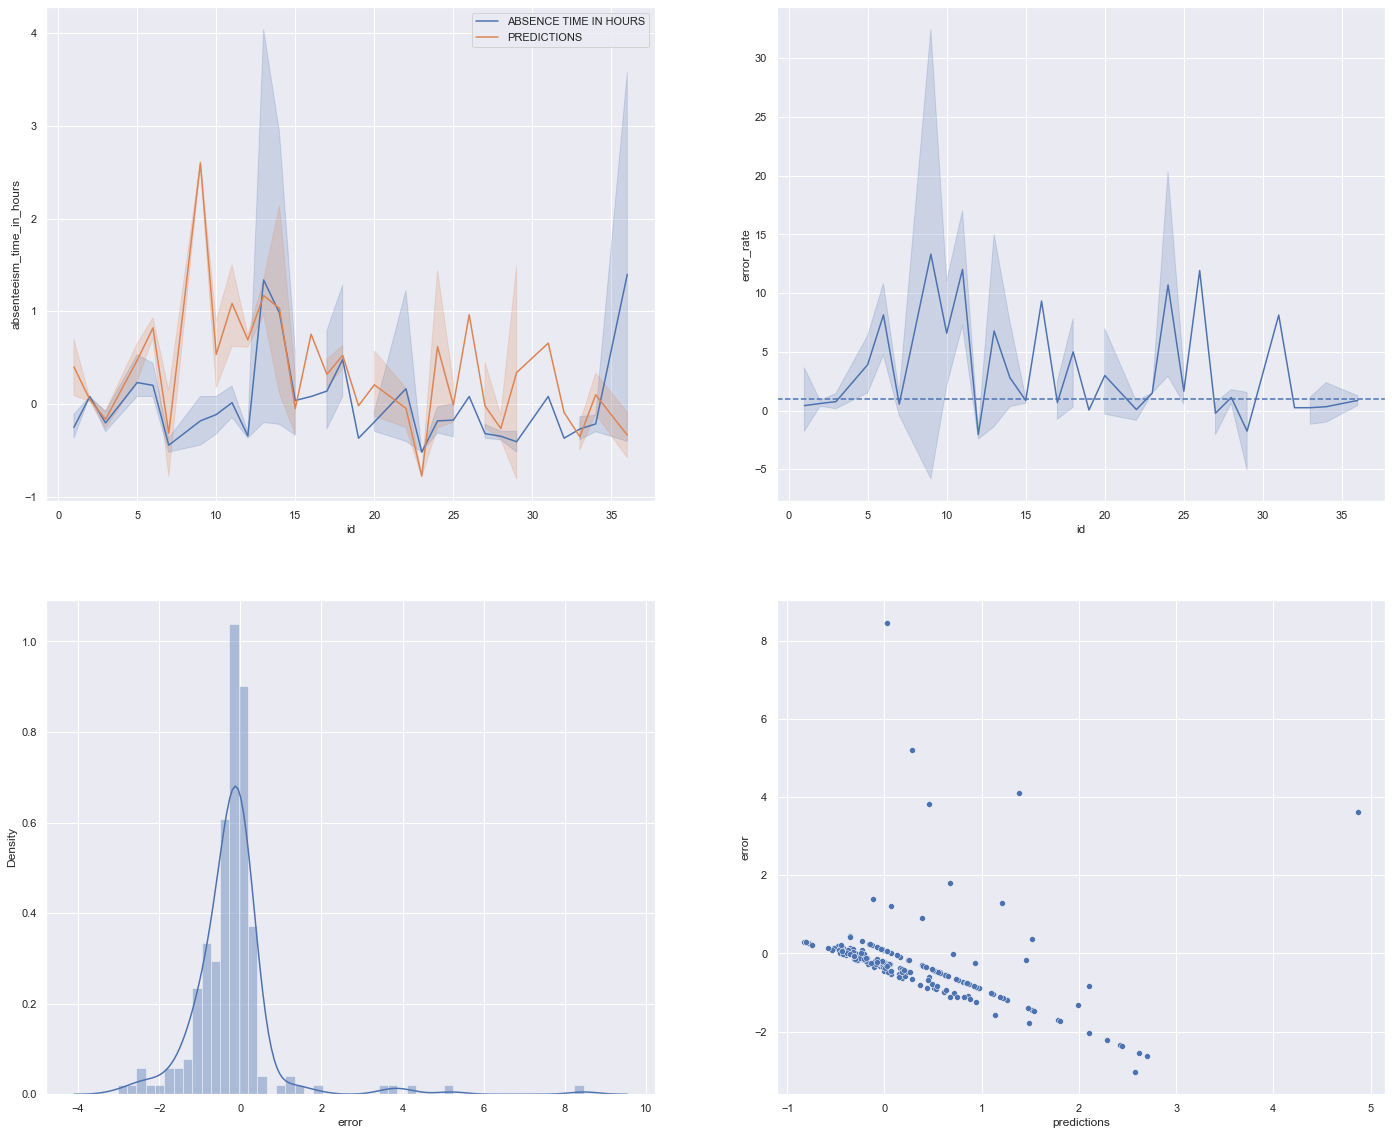

In [1559]:
plt.subplot(2, 2, 1)
sns.lineplot(x='id', y='absenteeism_time_in_hours', data=df9, label='ABSENCE TIME IN HOURS')
sns.lineplot(x='id', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='id', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10.0 DEPLOY MODEL TO PRODUCTION